In [2]:
from importlib import reload
import os
from toolz import pipe as p

import matplotlib.pyplot as plt
import numpy as np

from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import trainModel
import visualizeModel

import localResnet
import scrapDataHelpers

In [3]:
%matplotlib inline

In [4]:
device = torch.device("cuda")

# Load Images

In [5]:
def createDataloaders(data_dir, input_size=224): 
    xs = ['train', 'val']

    data_transforms = trainModel.create_data_transforms(input_size, input_size)
    
    image_datasets = {x: p(data_dir, 
                           lambda _:os.path.join(_, x),
                           lambda _: datasets.ImageFolder(_, data_transforms[x])
                          )
                      for x in xs}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers = 4)
                   for x in xs}

    dataset_sizes = {x: len(image_datasets[x]) for x in xs}
    
    return image_datasets, dataloaders, dataset_sizes

In [6]:
data_dir = 'scrap_data50/'
image_datasets, dataloaders, dataset_sizes = createDataloaders(data_dir)

In [7]:
class_names = image_datasets['train'].classes

In [8]:
n_classes = len(class_names)
print(class_names, n_classes)

['laughing', 'punching'] 2


In [9]:
scrapDataHelpers.classPercentages('scrap_data50/')

{('train', 'laughing'): 42.0,
 ('val', 'laughing'): 40.0,
 ('train', 'punching'): 57.99999999999999,
 ('val', 'punching'): 60.0}

# Visualize

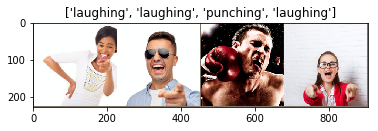

In [10]:
reload(visualizeModel)

inputs, classes = p(dataloaders['train'], iter, next)

out = torchvision.utils.make_grid(inputs)

visualizeModel.imshow(out, trainModel.defaultMn, trainModel.defaultSd, 
                      title=[class_names[x] for x in classes])

# Simple Model

In [11]:
reload(localResnet)
model = localResnet.ResNet([1, 1, 1, 1], n_classes).to(device)

In [12]:
model

ResNet(
  (preres): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): ResLayer(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): Sequential(
    (0): ResLayer(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.4)

In [14]:
model = trainModel.train_model(model, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/simple_resnet')
                              )

Epoch 0/24
----------
train Loss: 2.8882 Acc: 0.5800
val Loss: 14.2097 Acc: 0.6000
Epoch 1/24
----------
train Loss: 2.6499 Acc: 0.6600
val Loss: 48.4391 Acc: 0.6000
Epoch 2/24
----------
train Loss: 2.6703 Acc: 0.5800
val Loss: 2.0820 Acc: 0.6000
Epoch 3/24
----------
train Loss: 1.0647 Acc: 0.7400
val Loss: 0.5685 Acc: 0.7000
Epoch 4/24
----------
train Loss: 0.7987 Acc: 0.6400
val Loss: 2.1452 Acc: 0.4000
Epoch 5/24
----------
train Loss: 1.4034 Acc: 0.4200
val Loss: 0.5992 Acc: 0.7000
Epoch 6/24
----------
train Loss: 0.9179 Acc: 0.5200
val Loss: 0.4876 Acc: 0.7000
Epoch 7/24
----------
train Loss: 0.5303 Acc: 0.8000
val Loss: 0.4801 Acc: 0.8000
Epoch 8/24
----------
train Loss: 0.4145 Acc: 0.8000
val Loss: 0.4892 Acc: 0.7000
Epoch 9/24
----------
train Loss: 0.3764 Acc: 0.8600
val Loss: 0.4928 Acc: 0.7000
Epoch 10/24
----------
train Loss: 0.3598 Acc: 0.9000
val Loss: 0.5222 Acc: 0.7000
Epoch 11/24
----------
train Loss: 0.4429 Acc: 0.8000
val Loss: 0.5275 Acc: 0.7000
Epoch 12/24


# Visualize Results

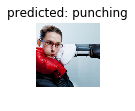

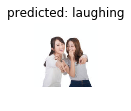

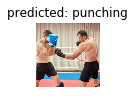

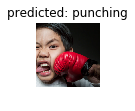

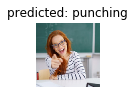

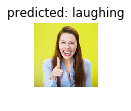

In [15]:
visualizeModel.visualize_model(model, dataloaders, device, class_names, 
                           trainModel.defaultMn, 
                           trainModel.defaultSd, k='val')